# Style Transcoders

In [1]:
# Autoreloading makes development easier
%load_ext autoreload
%autoreload 2

In [2]:
# Import libraries
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as krs
import tensorflow_probability as tfp
import json
from sklearn.model_selection import train_test_split
from tools.audio_tools import read_audio, write_audio, play_audio
from tools.feature_tools import compute_mels, compute_imels, compute_mfcc, compute_imfcc, load_data, normalize_features, denormalize_features
from tools.constants import npy_classical_path, npy_jazz_path, models_path
from tools.plot_tools import make_figax, plot_history, plot_audio, plot_spectral_feature
from tools.tensorflow_tools import tune_hyperparameters, load_optimal_params

2023-11-25 20:20:50.318066: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-25 20:20:50.318127: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-25 20:20:50.318175: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 20:20:50.327569: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Data Loading

### Load Audio & Extract Features

In [3]:
n_samples = 5000
n_samples = min(n_samples, len(os.listdir(npy_classical_path)), len(os.listdir(npy_jazz_path)))
print(f"{n_samples = }")

X_c_raw = load_data(npy_classical_path, n_samples=n_samples)
X_j_raw = load_data(npy_jazz_path, n_samples=n_samples)

print(f"{X_c_raw.shape = }")
print(f"{X_j_raw.shape = }")

n_samples = 5000
99 %
99 %
X_c_raw.shape = (5000, 67, 128, 1)
X_j_raw.shape = (5000, 67, 128, 1)


### Train - Validation - Test Split

In [4]:
# Fraction of data to keep apart for validation
test_size = round(0.1 * n_samples)
val_size = test_size
# Perform splits
X_c_raw_train, X_c_raw_test = train_test_split(X_c_raw, test_size=test_size)
X_c_raw_train, X_c_raw_val = train_test_split(X_c_raw_train, test_size=val_size)
X_j_raw_train, X_j_raw_test = train_test_split(X_j_raw, test_size=test_size)
X_j_raw_train, X_j_raw_val = train_test_split(X_j_raw_train, test_size=val_size)
# Verify split shapes
print(f"{X_c_raw_train.shape = }")
print(f"{X_c_raw_test.shape = }")
print(f"{X_c_raw_val.shape = }")
print(f"{X_j_raw_train.shape = }")
print(f"{X_j_raw_test.shape = }")
print(f"{X_j_raw_val.shape = }")

X_c_raw_train.shape = (4000, 67, 128, 1)
X_c_raw_test.shape = (500, 67, 128, 1)
X_c_raw_val.shape = (500, 67, 128, 1)
X_j_raw_train.shape = (4000, 67, 128, 1)
X_j_raw_test.shape = (500, 67, 128, 1)
X_j_raw_val.shape = (500, 67, 128, 1)


### Normalize Features

In [5]:
# Perform normalization
X_c_train, X_c_val, X_c_test = normalize_features(X_c_raw_train, X_raw_val=X_c_raw_val, X_raw_test=X_c_raw_test, name="classical")
X_j_train, X_j_val, X_j_test = normalize_features(X_j_raw_train, X_raw_val=X_j_raw_val, X_raw_test=X_j_raw_test, name="jazz")

print(f"{X_c_train.shape }")
print(f"{X_c_val.shape }")
print(f"{X_c_test.shape }")
print(f"{X_j_train.shape }")
print(f"{X_j_val.shape }")
print(f"{X_j_test.shape }")

(4000, 67, 128, 1)
(500, 67, 128, 1)
(500, 67, 128, 1)
(4000, 67, 128, 1)
(500, 67, 128, 1)
(500, 67, 128, 1)


In [6]:
input_shape = X_c_train.shape[1:]

print(f"{input_shape = }")

input_shape = (67, 128, 1)


## Style Transfer Models

### Test Script

In [7]:
# Test transcoder
def test_transcoder(transcoder, X_test=X_c_test, Y_test=X_j_test, plot_transforms=True):
    # Random picks
    print("Picking samples")
    X = np.expand_dims(X_test[np.random.choice(len(X_test))], axis=0)
    Y = np.expand_dims(Y_test[np.random.choice(len(Y_test))], axis=0)
    print(f"{X.shape = }")
    print(f"{Y.shape = }")
    
    # Transcode
    print("Performing transcode")
    Y_fake = transcoder.transcode(X, XtoY=True)
    X_fake = transcoder.transcode(Y, XtoY=False)
    
    # Reconstruct raw spectra
    print("Denormalizing")
    X_raw = denormalize_features(X, name="classical")
    X_raw_fake = denormalize_features(X_fake, name="classical")
    Y_raw = denormalize_features(Y, name="jazz")
    Y_raw_fake = denormalize_features(Y_fake, name="jazz")
    
    # Plot raw spectra
    if plot_transforms:
        print("Plotting transforms")
        fig, ax = plot_spectral_feature(X_raw)
        ax.set_title("Classical Spectrum")
        fig, ax = plot_spectral_feature(X_raw_fake)
        ax.set_title(r"Jazz $\rightarrow$ Classical Spectrum")
        fig, ax = plot_spectral_feature(Y_raw)
        ax.set_title("Jazz Spectrum")
        fig, ax = plot_spectral_feature(Y_raw_fake)
        ax.set_title(r"Classical $\rightarrow$ Jazz Spectrum")
        plt.show()
    
    # Reconstruct audio
    print("Reconstructing audio")
    sX = np.squeeze(compute_imels(np.squeeze(X_raw)))
    sX_fake = np.squeeze(compute_imels(np.squeeze(X_raw_fake)))
    sY = np.squeeze(compute_imels(np.squeeze(Y_raw)))
    sY_fake = np.squeeze(compute_imels(np.squeeze(Y_raw_fake)))
    
    # Play audio
    print("Classical audio")
    player = play_audio(sX)
    print("Jazz to Classical audio")
    player = play_audio(sX_fake)
    print("Jazz audio")
    player = play_audio(sY)
    print("Classical to Jazz audio")
    player = play_audio(sY_fake)    

### Convolutional Style Transfer

In [9]:
from models.transcoders import Conv2DTranscoder

In [31]:
default_params = {
    "feature_shape": input_shape,
    "compression": 4,
    "kernel_size": 5,
    "conv_depth": 2,
    "input_chans_multiplier": 1,
    "skip_connection": False,
    "pooling_type": "average",
    "h_reg": 1e-1,
    "kl_reg": 0.,
}
results_path = os.path.join("./results/ConvolutionalTranscoder")
os.makedirs(results_path, exist_ok=True)

In [32]:
# Construct model
transcoder = Conv2DTranscoder(**default_params)
transcoder.compile(optimizer="adam")

In [33]:
# Train model
history = transcoder.fit(X_c_train, X_j_train, epochs=10, shuffle=True, validation_data=(X_c_val, X_j_val), verbose=1)

Epoch 1/10
125/125 [==============================] - 9s 27ms/step - loss: 0.1773 - r_loss: 0.1755 - h_loss: 0.0177 - kl_loss: 0.3322 - val_loss: 0.1527 - val_r_loss: 0.1504 - val_h_loss: 0.0235 - val_kl_loss: 0.0037
Epoch 2/10
125/125 [==============================] - 3s 20ms/step - loss: 0.1435 - r_loss: 0.1408 - h_loss: 0.0263 - kl_loss: 0.0130 - val_loss: 0.1352 - val_r_loss: 0.1326 - val_h_loss: 0.0255 - val_kl_loss: 0.0039
Epoch 3/10
125/125 [==============================] - 2s 20ms/step - loss: 0.1303 - r_loss: 0.1277 - h_loss: 0.0263 - kl_loss: 0.0172 - val_loss: 0.1235 - val_r_loss: 0.1210 - val_h_loss: 0.0250 - val_kl_loss: 0.0019
Epoch 4/10
125/125 [==============================] - 2s 20ms/step - loss: 0.1187 - r_loss: 0.1160 - h_loss: 0.0271 - kl_loss: 0.0187 - val_loss: 0.1131 - val_r_loss: 0.1103 - val_h_loss: 0.0279 - val_kl_loss: 0.0018
Epoch 5/10
125/125 [==============================] - 2s 20ms/step - loss: 0.1098 - r_loss: 0.1072 - h_loss: 0.0261 - kl_loss: 0.012

Picking samples
X.shape = (1, 67, 128, 1)
Y.shape = (1, 67, 128, 1)
Performing transcode
Denormalizing
Plotting transforms


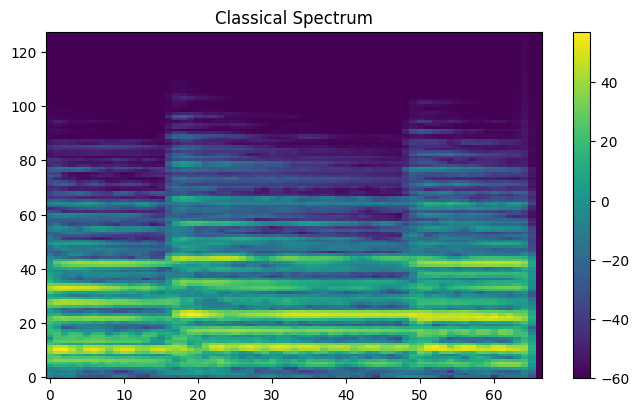

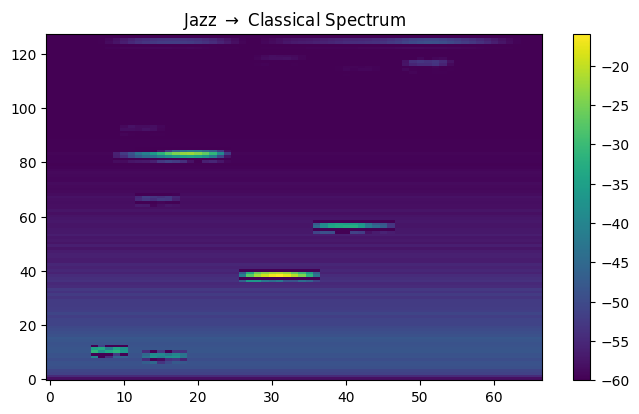

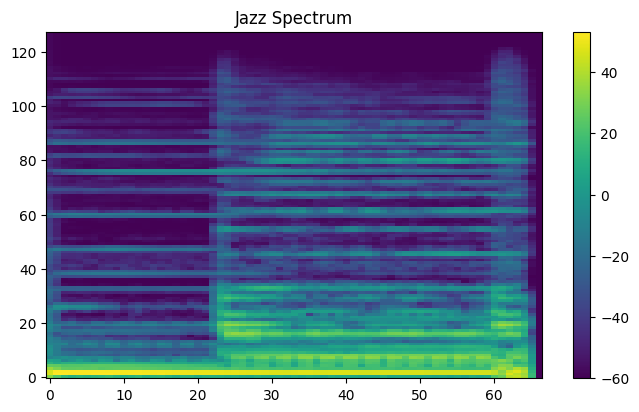

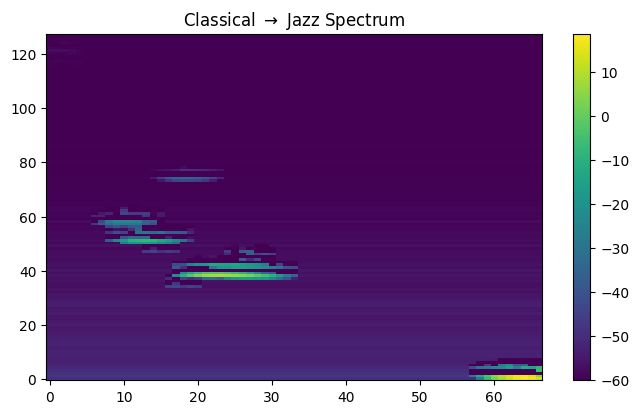

Reconstructing audio
Classical audio


Jazz to Classical audio


Jazz audio


Classical to Jazz audio


In [37]:
# Test model
test_transcoder(transcoder)

In [35]:
# Save model
transcoder.save_weights(os.path.join(results_path, "model"))

In [36]:
# Load model
transcoder = Conv2DTranscoder(**default_params)
transcoder.load_weights(os.path.join(results_path, "model"))

### Variational Style Transfer

In [41]:
from models.transcoders import VariationalTranscoder

In [66]:
default_params = {
    "feature_shape": input_shape,
    "compression": 4,
    "kernel_size": 5,
    "conv_depth": 2,
    "input_chans_multiplier": 1,
    "skip_connection": False,
    "pooling_type": "average",
    "h_reg": 1e-3,
    "kl_reg": 1e-5,
}
results_path = os.path.join("./results/VariationalTranscoder")
os.makedirs(results_path, exist_ok=True)

In [67]:
# Construct model
transcoder = VariationalTranscoder(**default_params)
transcoder.compile(optimizer="adam")

In [68]:
# Train model w/o regularization
history = transcoder.fit(X_c_train, X_j_train, epochs=25, shuffle=True, validation_data=(X_c_val, X_j_val), verbose=1)

Epoch 1/25
125/125 [==============================] - 11s 35ms/step - loss: 0.2322 - r_loss: 0.2316 - h_loss: 0.5647 - kl_loss: 0.6416 - val_loss: 0.2055 - val_r_loss: 0.2050 - val_h_loss: 0.4574 - val_kl_loss: 0.2249
Epoch 2/25
125/125 [==============================] - 3s 25ms/step - loss: 0.2049 - r_loss: 0.2044 - h_loss: 0.4813 - kl_loss: 0.2542 - val_loss: 0.2042 - val_r_loss: 0.2037 - val_h_loss: 0.5470 - val_kl_loss: 0.5852
Epoch 3/25
125/125 [==============================] - 3s 25ms/step - loss: 0.1877 - r_loss: 0.1869 - h_loss: 0.7811 - kl_loss: 3.1172 - val_loss: 0.1750 - val_r_loss: 0.1741 - val_h_loss: 0.8483 - val_kl_loss: 3.0510
Epoch 4/25
125/125 [==============================] - 3s 25ms/step - loss: 0.3127 - r_loss: 0.3113 - h_loss: 1.4018 - kl_loss: 2.9373 - val_loss: 0.1658 - val_r_loss: 0.1650 - val_h_loss: 0.8136 - val_kl_loss: 2.8692
Epoch 5/25
125/125 [==============================] - 3s 25ms/step - loss: 0.1622 - r_loss: 0.1611 - h_loss: 0.9712 - kl_loss: 4.15

Picking samples
X.shape = (1, 67, 128, 1)
Y.shape = (1, 67, 128, 1)
Performing transcode
Denormalizing
Plotting transforms


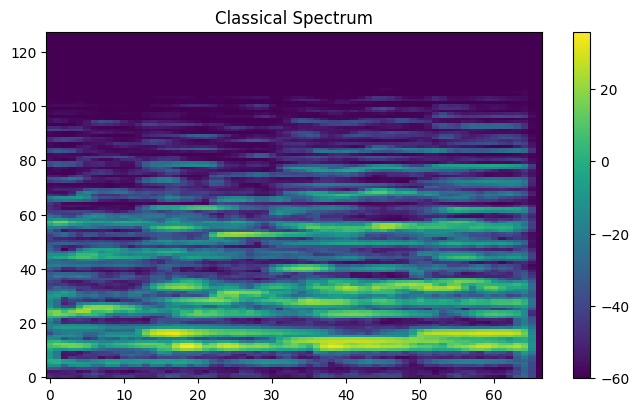

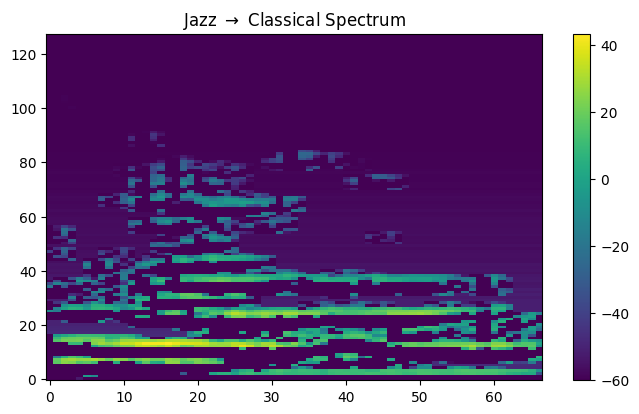

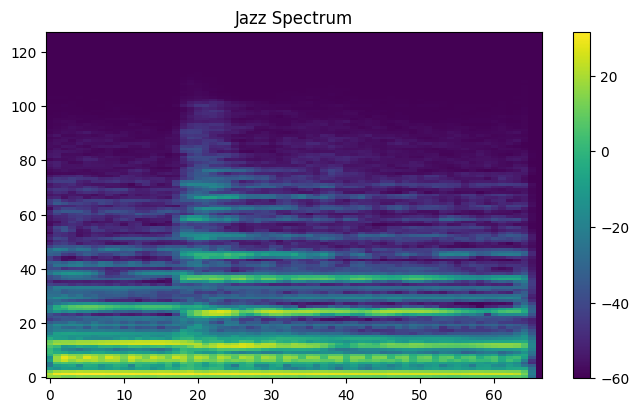

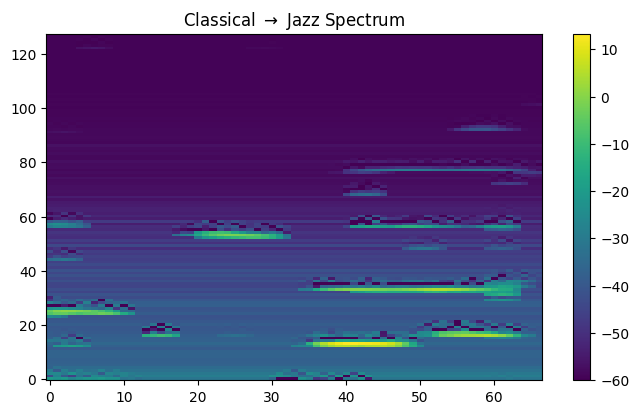

Reconstructing audio
Classical audio


Jazz to Classical audio


Jazz audio


Classical to Jazz audio


In [76]:
# Test transcoder
test_transcoder(transcoder)

In [74]:
# Save transcoder
transcoder.save_weights(os.path.join(results_path, "model"))

In [75]:
# Load transcoder
transcoder.load_weights(os.path.join(results_path, "model"))

### GAN Style Transfer

In [64]:
from models.transcoders import GANTranscoder, GANDiscriminators
from models.layers import GAN

In [65]:
def create_gan_model(**params):
    # Split generator & discriminator params
    g_params = {}
    d_params = {}
    for key, value in params.items():
        if key[:2] == "g_":
            # Generator param
            g_params[key[2:]] = value
        elif key[:2] == "d_":
            # Discriminator param
            d_params[key[2:]] = value
        else:
            # Shared param
            g_params[key] = value
            d_params[key] = value
    
    generator = GANTranscoder(**g_params)
    discriminator = GANDiscriminators(**d_params)
    gan = GAN(generator, discriminator)
    return gan

In [66]:
default_params = {
    "feature_shape": input_shape,
    "g_compression": 8,
    "g_kernel_size": 3,
    "g_conv_depth": 1,
    "g_input_chans_multiplier": 1,
    "g_skip_connection": False,
    "g_pooling_type": "average",
    "g_gan_reg": 0.1,
    "g_c_reg": 0.1,
    "g_s_reg": 0.1,
    "d_mlp_layers": 2,
    "d_conv_compression": 8,
    "d_conv_kernel_size": 3,
    "d_conv_pooling_type": "max",
}

compile_kwargs={
    "g_optimizer": "adam",
    "d_optimizer": "adam",
}

In [71]:
# Test training
gan = create_gan_model(**default_params)
gan.compile(**compile_kwargs)
history = gan.fit(X_c_train, X_j_train, epochs=1, shuffle=True, verbose=1, validation_data=(X_c_val, X_j_val))

11/11 [==============================] - 15s 480ms/step - loss: 0.4439 - r_loss: 0.2347 - gan_loss: 1.2818 - c_loss: 0.0095 - s_loss: 0.8003 - d_loss: 0.8201 - val_loss: 0.4992 - val_r_loss: 0.2401 - val_gan_loss: 1.7821 - val_c_loss: 0.0066 - val_s_loss: 0.8020 - val_d_loss: 0.4678


In [72]:
# Hyperparameter tuning
results_path = os.path.join("./results/GANTranscoder")
os.makedirs(results_path, exist_ok=True)
keys = np.array([
    "g_gan_reg",
    "g_c_reg",
    "g_s_reg",
    "g_input_chans_multiplier",
    "g_conv_depth",
    "g_kernel_size",
    "g_pooling_type",
])
vals = np.array([
    [1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5],
    [1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5],
    [1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5],
    [1, 2, 4],
    [1, 2, 3],
    [3, 5],
    ["max", "average"],
], dtype="object")
loss_key="val_r_loss"
epochs = 250
passes = 1
optimal_params = default_params.copy()

In [ ]:
# Random optimization
optimal_params, optimal_loss = tune_hyperparameters(
    X_c_train,
    X_j_train,
    create_gan_model,
    default_params,
    keys,
    vals,
    loss_key,
    X_val=X_c_val,
    y_val=X_j_val,
    results_path=results_path,
    epochs=epochs,
    verbose=False,
    do_random=True,
    random_attempts=25,
    compile_kwargs=compile_kwargs,
)

In [ ]:
print(f"{optimal_params = }")
print(f"{optimal_loss = }")

In [ ]:
# Sequential optimization
for i in range(passes):
    # Random optimization
    permutation = np.random.permutation(len(keys))
    optimal_params, optimal_loss = tune_hyperparameters(
        X_c_train,
        X_j_train,
        create_gan_model,
        default_params,
        keys,
        vals,
        loss_key,
        X_val=X_c_val,
        y_val=X_j_val,
        results_path=results_path,
        epochs=epochs,
        verbose=False,
        do_random=False,
        compile_kwargs=compile_kwargs,
    )

In [ ]:
print(f"{optimal_params = }")
print(f"{optimal_loss = }")

In [ ]:
# Load optimal hyperparameters from tuning process
optimal_params, optimal_loss = load_optimal_params(results_path, loss_key)

In [ ]:
print(f"{optimal_params = }")
print(f"{optimal_loss = }")

In [ ]:
# Retrain with optimal params
gan = create_gan_model(**optimal_params)
gan.compile(**compile_kwargs)
earlystopping = krs.callbacks.EarlyStopping(monitor=loss_key, patience=5, min_delta=1e-6)
history = gan.fit(X_train, X_train, epochs=250, shuffle=True, validation_data=(X_val, X_val), callbacks=[earlystopping], verbose=1)